In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import math

from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv("./data/amf-performance.csv")
df['datetime'] = pd.to_datetime(df['time'], unit='s') # resample function needs a datetime column
df = df.drop(['time', 'lat75', 'lat80', 'lat90', 'lat95', 'lat98', 'lat99', 'lat100'], axis=1)

frequency = '1h'

# additional features
df['day'] = pd.DatetimeIndex(df['datetime']).day
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

# Remove from ram_limit 'M' and convert the column to integer
df['ram_limit'] = df['ram_limit'].str.replace('M', '').astype(int)

df_max = df.resample(frequency, on='datetime').max()
df_max

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,day,hour
datetime,,,,,,,,,
2021-11-10 14:00:00,2048.0,2.0,1.130758e+09,1.276808,500.0,60398090.0,60414274.0,10.0,14.0
2021-11-10 15:00:00,2048.0,2.0,1.559351e+09,0.996645,460.0,93936583.0,94259814.0,10.0,15.0
2021-11-10 16:00:00,2048.0,2.0,1.494233e+09,0.983066,480.0,95931083.0,96020918.0,10.0,16.0
2021-11-10 17:00:00,2048.0,2.0,1.600532e+09,0.983279,480.0,97132575.0,97360300.0,10.0,17.0
2021-11-10 18:00:00,2048.0,2.0,1.010856e+09,0.999460,440.0,97207925.0,97417298.0,10.0,18.0
...,...,...,...,...,...,...,...,...,...
2021-11-27 04:00:00,1280.0,2.0,1.753735e+09,1.323356,550.0,98065398.0,98048590.0,27.0,4.0
2021-11-27 05:00:00,4096.0,2.0,1.023115e+09,1.257932,550.0,98199627.0,98221357.0,27.0,5.0
2021-11-27 06:00:00,3840.0,1.5,1.836081e+09,1.324840,550.0,96423698.0,96467143.0,27.0,6.0


C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_20288\1767674588.py:11: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


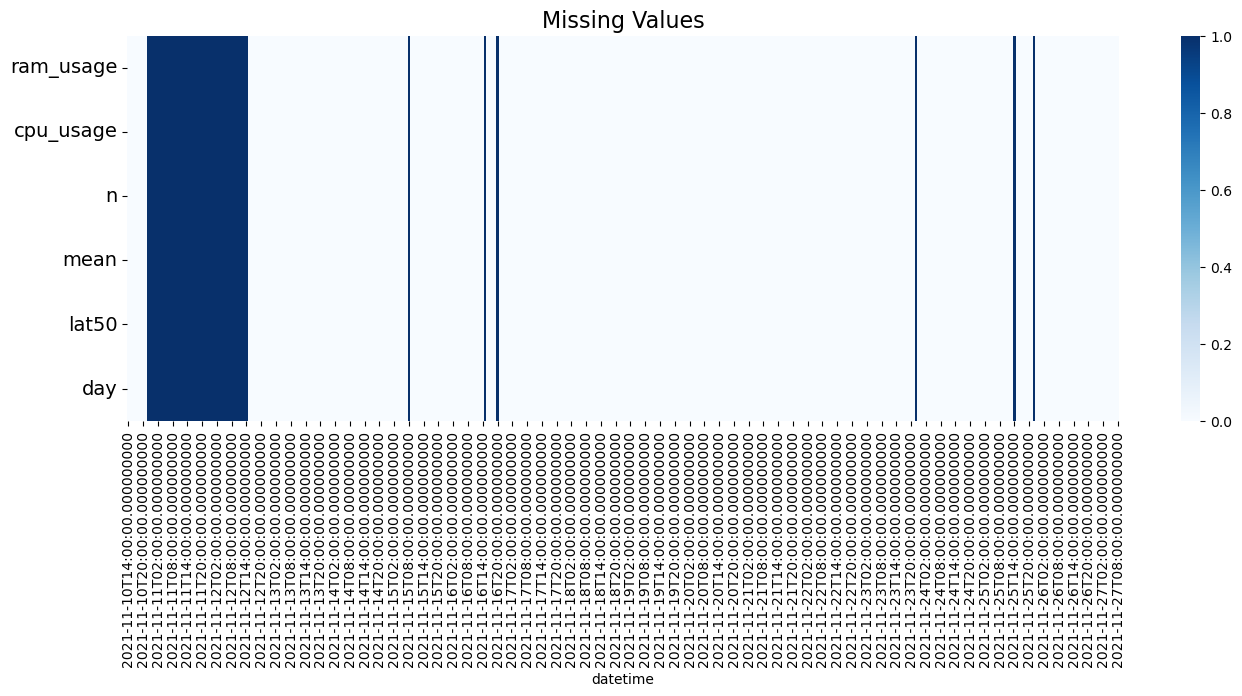

In [4]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df_max.iloc[:,2:-1].T.isna(), cmap='Blues') #drop useless columns
ax.set_title('Missing Values', fontsize=16)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Set the rotation angle as needed


for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

Remove the big portion of missing values

In [5]:
# Set the filter condition based on the desired date and time
df_max_reset = df_max.reset_index()
df_max_reset['datetime'] = pd.to_datetime(df_max_reset['datetime'])
filter_condition = df_max_reset['datetime'] > '2021-11-12 14:00:00'

# Apply the filter to get the subset of the DataFrame
filtered_df = df_max_reset[filter_condition].set_index('datetime')

Plot filtered datafarame

C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_20288\3090262208.py:11: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


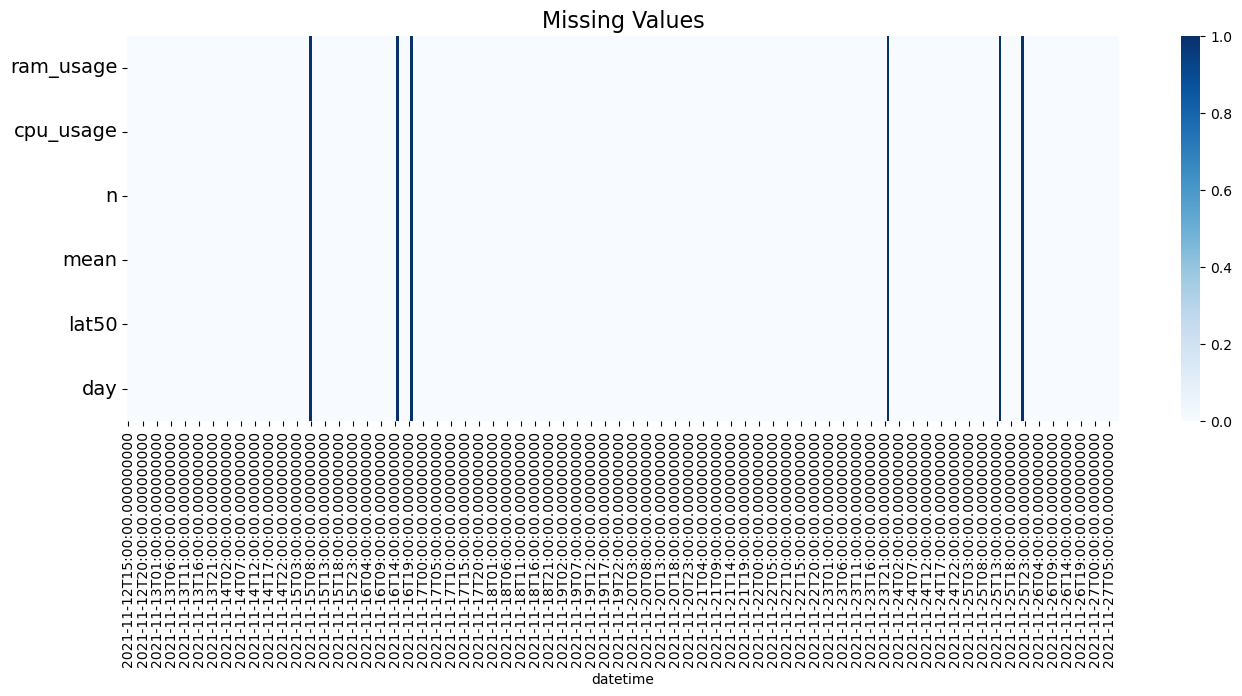

In [6]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(filtered_df.iloc[:,2:-1].T.isna(), cmap='Blues') #drop useless columns
ax.set_title('Missing Values', fontsize=16)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Set the rotation angle as needed


for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

Interpolate in order to fill the null values in the df

In [7]:
interpolated_df = filtered_df.interpolate()
interpolated_df.isna().sum()

ram_limit    0
cpu_limit    0
ram_usage    0
cpu_usage    0
n            0
mean         0
lat50        0
day          0
hour         0
dtype: int64

In [8]:
interpolated_df

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,day,hour
datetime,,,,,,,,,
2021-11-12 15:00:00,4096.0,4.0,1.203683e+09,1.358302,520.0,67451009.0,67428077.0,12.0,15.0
2021-11-12 16:00:00,3584.0,4.0,1.870483e+09,1.385498,520.0,68222008.0,68162522.0,12.0,16.0
2021-11-12 17:00:00,3072.0,4.0,1.847726e+09,1.382358,550.0,77777013.0,77747786.0,12.0,17.0
2021-11-12 18:00:00,2304.0,4.0,1.854063e+09,1.358083,530.0,70557306.0,70546856.0,12.0,18.0
2021-11-12 19:00:00,1280.0,4.0,1.766617e+09,1.307712,520.0,68996878.0,68965997.0,12.0,19.0
...,...,...,...,...,...,...,...,...,...
2021-11-27 04:00:00,1280.0,2.0,1.753735e+09,1.323356,550.0,98065398.0,98048590.0,27.0,4.0
2021-11-27 05:00:00,4096.0,2.0,1.023115e+09,1.257932,550.0,98199627.0,98221357.0,27.0,5.0
2021-11-27 06:00:00,3840.0,1.5,1.836081e+09,1.324840,550.0,96423698.0,96467143.0,27.0,6.0


# LSTM for univariate forecasting 
Data scaling using MinMaxScaler

In [9]:
cpu_usage_df = interpolated_df.filter(['cpu_usage'])

#Convert the dataframe to a numpy array
cpu_usage_array = cpu_usage_df.values

scaler = MinMaxScaler(feature_range=(0, 1))
cpu_usage_scaled = scaler.fit_transform(cpu_usage_array)

print(len(cpu_usage_scaled))
cpu_usage_scaled[:10]

354


array([[0.92479045],
       [0.9481782 ],
       [0.94547789],
       [0.92460211],
       [0.88128455],
       [0.87150325],
       [0.8771266 ],
       [0.86608028],
       [0.73260517],
       [0.87998514]])

Choose window size

In [11]:
# load previous evaluation computed with different window size
rolling_window_evaluation = pd.read_csv('./data/LSTM_1h_windows_size.csv')
rolling_window_evaluation

,window,train_MAE,train_MAPE,train_RMSE,test_MAE,test_MAPE,test_RMSE
0,1,0.225235,0.307484,0.289291,0.230882,0.320936,0.300985
1,3,0.205322,0.274398,0.266321,0.218298,0.292817,0.280496
2,6,0.223968,0.297594,0.285243,0.230219,0.306603,0.290904
3,12,0.199910,0.251140,0.259933,0.248088,0.310985,0.314542
4,15,0.191826,0.246098,0.250868,0.241185,0.304582,0.311060
5,24,0.210859,0.306253,0.271712,0.243619,0.345747,0.318123
6,48,0.150987,0.204071,0.217123,0.262116,0.351708,0.332074
7,96,0.163382,0.228637,0.261908,0.291277,0.390428,0.348005
8,120,0.292580,0.293247,0.399549,0.472846,0.415973,0.551462


C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_4044\329631653.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax = rolling_window_evaluation.plot(kind='bar', x='window', y=rolling_window_evaluation.columns.drop('window'), legend=True, width=0.9, colormap=get_cmap('viridis'))


<Figure size 2000x500 with 0 Axes>

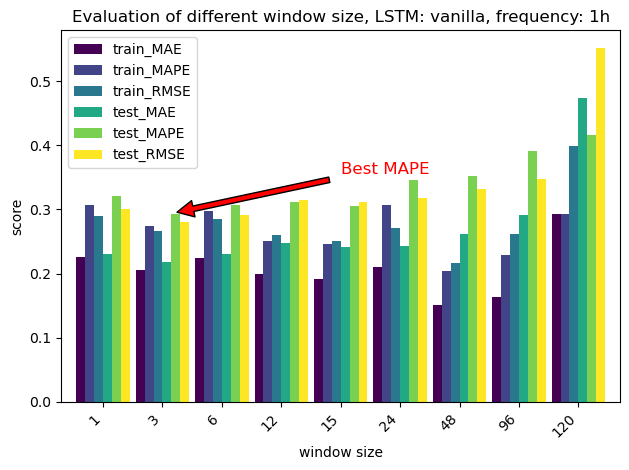

In [ ]:
# plot window size evaluation metrics
plt.figure(figsize=(20,5))

ax = rolling_window_evaluation.plot(kind='bar', x='window', y=rolling_window_evaluation.columns.drop('window'), legend=True, width=0.9, colormap=get_cmap('viridis'))

plt.legend()
plt.title('Evaluation of different window size, LSTM: vanilla, frequency: 1h')
plt.xlabel('window size')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylabel('score')
plt.tight_layout()

# Add an annotation with an arrow pointing to a specific point
min_MAPE = min(rolling_window_evaluation['test_MAPE'])
arrow_point = (1.1, min_MAPE)  # Specify the coordinates of the point to annotate
arrow_text = 'Best MAPE'  # Text to display in the annotation

ax.annotate(arrow_text, arrow_point, xytext=(4, 0.35),
            arrowprops=dict(facecolor='red', shrink=0.05),
            fontsize=12, color='red', horizontalalignment='left', verticalalignment='bottom')

plt.show()

<sub><sup>With an LSTM vanilla and a data sample of 1h, the best window size option on test set seems to be 3h </sup></sub>

Prepare training and test sets

In [ ]:
# Defines the rolling window
look_back = 3

In [ ]:
# define train and test size
train_size = int(0.7 * len(cpu_usage_df))
test_size = len(cpu_usage_df) - train_size

# Split into train and test sets
train, test = cpu_usage_scaled[:train_size-look_back,:], cpu_usage_scaled[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

241 107


Vanilla LSTM 
- a single hidden layer of LSTM units

In [ ]:
# build the vanilla LSTM model
model = tf.keras.Sequential()
model.add(LSTM(50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

# train the model
#model.fit(x_train, y_train, batch_size=1, epochs=100, callbacks=[early_stopping], validation_data=(x_test, y_test))
model.fit(x_train, y_train, batch_size=1, epochs=100, callbacks=[early_stopping], validation_split=0.3)

model.summary()

Epoch 1/100
168/168 [==============================] - 5s 10ms/step - loss: 0.2190 - val_loss: 0.0851
Epoch 2/100
168/168 [==============================] - 1s 5ms/step - loss: 0.0616 - val_loss: 0.0825
Epoch 3/100
168/168 [==============================] - 1s 5ms/step - loss: 0.0609 - val_loss: 0.0809
Epoch 4/100
168/168 [==============================] - 1s 5ms/step - loss: 0.0588 - val_loss: 0.0801
Epoch 5/100
168/168 [==============================] - 1s 5ms/step - loss: 0.0568 - val_loss: 0.0779
Epoch 6/100
168/168 [==============================] - 1s 5ms/step - loss: 0.0569 - val_loss: 0.0779
Epoch 7/100
168/168 [==============================] - 1s 5ms/step - loss: 0.0558 - val_loss: 0.0773
Epoch 8/100
168/168 [==============================] - 1s 5ms/step - loss: 0.0548 - val_loss: 0.0757
Epoch 9/100
168/168 [==============================] - 1s 5ms/step - loss: 0.0561 - val_loss: 0.0766
Epoch 10/100
168/168 [==============================] - 1s 5ms/step - loss: 0.0552 - val_l

Vanilla LSTM prediction and evaluation

In [ ]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + '--- TEST metrics ---')
print(Fore.GREEN + 'RMSE: {}, MAE: {}, MAPE: {}'.format(score_rmse, score_mae, score_mape))

4/4 [==============================] - 0s 5ms/step
--- TEST metrics ---
RMSE: 0.2807235489983016, MAE: 0.22513523472067573, MAPE: 0.2920583695659368


In [ ]:
# Calculate evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
train_mae = mean_absolute_error(y_train[0], train_predict[:,0])
train_mape = mean_absolute_percentage_error(y_train[0], train_predict[:,0])
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
test_mae = mean_absolute_error(y_test[0], test_predict[:,0])
test_mape = mean_absolute_percentage_error(y_test[0], test_predict[:,0])


# Print evaluation metrics
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAE: {train_mae:.2f}')
print(f'Training MAPE: {train_mape:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Test MAPE: {test_mape:.2f}')

Training RMSE: 0.27
Training MAE: 0.22
Training MAPE: 0.28
Test RMSE: 0.28
Test MAE: 0.23
Test MAPE: 0.29


Plot results of LSTM univariate forecasting

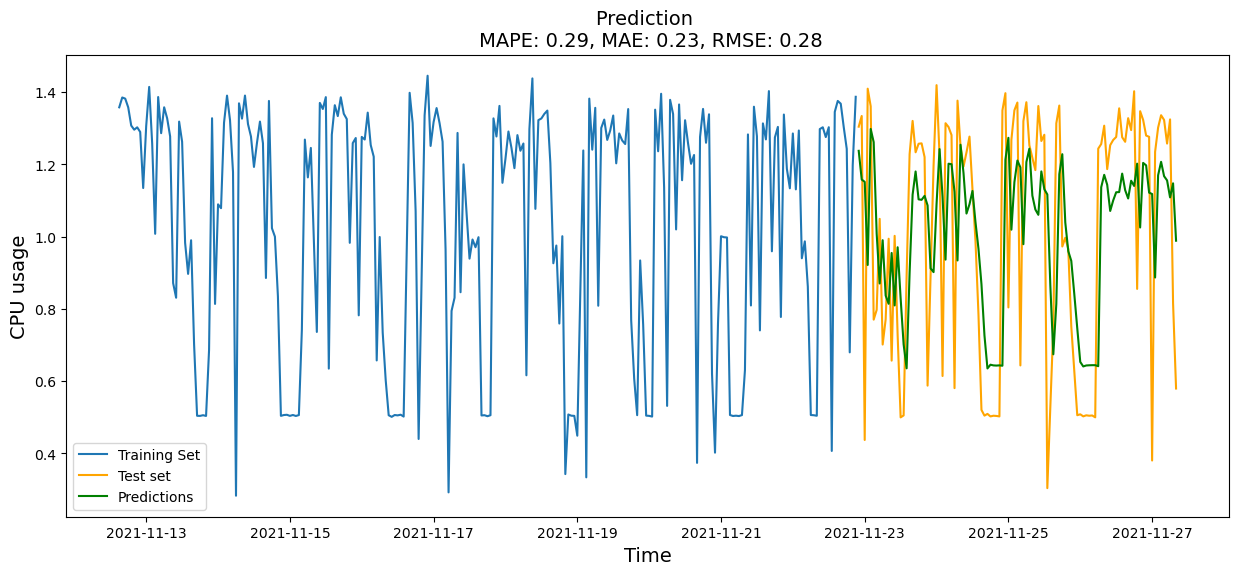

In [ ]:
cpu_usage_df = cpu_usage_df.reset_index()
x_train_ticks = cpu_usage_df.head(train_size)['datetime']
y_train = cpu_usage_df.head(train_size)['cpu_usage']
x_test_ticks = cpu_usage_df.tail(test_size)['datetime']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Training Set') 
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Test set') 
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Predictions') 

ax.set_title(f'Prediction \n MAPE: {score_mape:.2f}, MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Time', fontsize=14)
ax.set_ylabel(ylabel='CPU usage', fontsize=14)

plt.show()

Prepare training and test sets

In [ ]:
# define train and test size
train_size = int(0.7 * len(cpu_usage_df))
test_size = len(cpu_usage_df) - train_size

# Split into train and test sets
train, test = cpu_usage_scaled[:train_size-look_back,:], cpu_usage_scaled[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

241 107


In [ ]:
y_test.shape

(107,)

LSTM definition and training

In [ ]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=100, callbacks=[early_stopping], validation_split=0.3)

model.summary()

Epoch 1/100
168/168 [==============================] - 14s 25ms/step - loss: 0.1030 - val_loss: 0.0789
Epoch 2/100
168/168 [==============================] - 1s 8ms/step - loss: 0.0601 - val_loss: 0.0791
Epoch 3/100
168/168 [==============================] - 1s 8ms/step - loss: 0.0575 - val_loss: 0.0913
Epoch 4/100
168/168 [==============================] - 1s 8ms/step - loss: 0.0603 - val_loss: 0.0764
Epoch 5/100
168/168 [==============================] - 1s 8ms/step - loss: 0.0579 - val_loss: 0.0773
Epoch 6/100
168/168 [==============================] - 1s 8ms/step - loss: 0.0589 - val_loss: 0.0814
Epoch 7/100
168/168 [==============================] - 1s 8ms/step - loss: 0.0591 - val_loss: 0.0826
Epoch 8/100
168/168 [==============================] - 1s 8ms/step - loss: 0.0625 - val_loss: 0.0768
Epoch 9/100
168/168 [==============================] - 1s 8ms/step - loss: 0.0596 - val_loss: 0.0755
Epoch 10/100
168/168 [==============================] - 1s 8ms/step - loss: 0.0546 - val_

LSTM prediction and evaluation

In [ ]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}, MAE: {}, MAPE: {}'.format(score_rmse, score_mae, score_mape))

4/4 [==============================] - 0s 5ms/step
RMSE: 0.29329578869548145, MAE: 0.2351200573798206, MAPE: 0.31197198943110993


Plot results of LSTM univariate forecasting

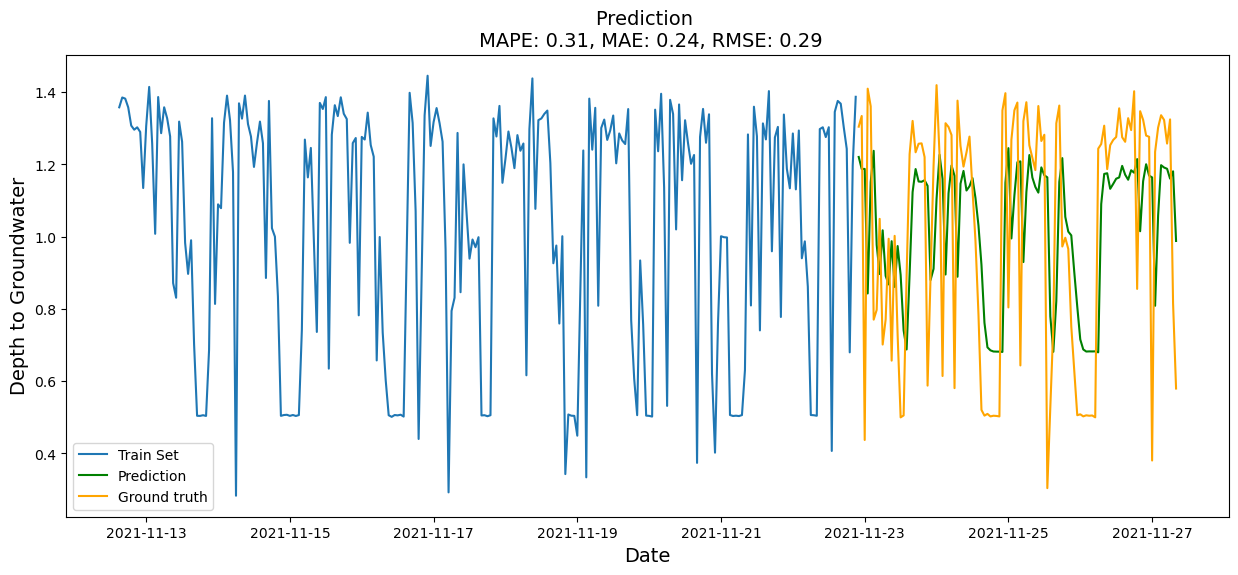

In [ ]:
cpu_usage_df = cpu_usage_df.reset_index()
x_train_ticks = cpu_usage_df.head(train_size)['datetime']
y_train = cpu_usage_df.head(train_size)['cpu_usage']
x_test_ticks = cpu_usage_df.tail(test_size)['datetime']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') 
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') 
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') 

ax.set_title(f'Prediction \n MAPE: {score_mape:.2f}, MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

this is a single-step LSTM, which means that for every tuple of input (decided in the training phase) it predicts 1 value

In [ ]:
input = x_test[0]
input

array([[0.34137119, 0.78696646, 0.94982246]])

In [ ]:
test_predict = model.predict(input.reshape(1,1,3))
test_predict

1/1 [==============================] - 0s 40ms/step


array([[0.8065578]], dtype=float32)

## Multi-step LSTM
For every tuple of input, predict multiple values

Prepare data

In [14]:
interpolated_df

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,day,hour
datetime,,,,,,,,,
2021-11-12 15:00:00,4096.0,4.0,1.203683e+09,1.358302,520.0,67451009.0,67428077.0,12.0,15.0
2021-11-12 16:00:00,3584.0,4.0,1.870483e+09,1.385498,520.0,68222008.0,68162522.0,12.0,16.0
2021-11-12 17:00:00,3072.0,4.0,1.847726e+09,1.382358,550.0,77777013.0,77747786.0,12.0,17.0
2021-11-12 18:00:00,2304.0,4.0,1.854063e+09,1.358083,530.0,70557306.0,70546856.0,12.0,18.0
2021-11-12 19:00:00,1280.0,4.0,1.766617e+09,1.307712,520.0,68996878.0,68965997.0,12.0,19.0
...,...,...,...,...,...,...,...,...,...
2021-11-27 04:00:00,1280.0,2.0,1.753735e+09,1.323356,550.0,98065398.0,98048590.0,27.0,4.0
2021-11-27 05:00:00,4096.0,2.0,1.023115e+09,1.257932,550.0,98199627.0,98221357.0,27.0,5.0
2021-11-27 06:00:00,3840.0,1.5,1.836081e+09,1.324840,550.0,96423698.0,96467143.0,27.0,6.0


In [15]:
cpu_usage_df = interpolated_df.filter(['cpu_usage'])

#Convert the dataframe to a numpy array
cpu_usage_array = cpu_usage_df.values

scaler = MinMaxScaler(feature_range=(0, 1))
cpu_usage_scaled = scaler.fit_transform(cpu_usage_array)

print(len(cpu_usage_scaled))
cpu_usage_scaled[:10]

354


array([[0.92479045],
       [0.9481782 ],
       [0.94547789],
       [0.92460211],
       [0.88128455],
       [0.87150325],
       [0.8771266 ],
       [0.86608028],
       [0.73260517],
       [0.87998514]])

In [16]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
			
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [17]:
cpu_usage_sequence = series_to_supervised(cpu_usage_scaled, 1, 3)
cpu_usage_sequence

,var1(t-1),var1(t),var1(t+1),var1(t+2)
1,0.924790,0.948178,0.945478,0.924602
2,0.948178,0.945478,0.924602,0.881285
3,0.945478,0.924602,0.881285,0.871503
4,0.924602,0.881285,0.871503,0.877127
5,0.881285,0.871503,0.877127,0.866080
...,...,...,...,...
347,0.818862,0.876385,0.905962,0.894738
348,0.876385,0.905962,0.894738,0.838475
349,0.905962,0.894738,0.838475,0.896014
350,0.894738,0.838475,0.896014,0.458343


In [18]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [19]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [20]:
# configure
n_lag = 1
n_seq = 7
n_test = 10

# prepare data
scaler, train, test = prepare_data(pd.DataFrame(cpu_usage_scaled), n_test, n_lag, n_seq)

In [21]:
train

array([[-0.02597023, -0.05535382, -0.07582528, ..., -0.04597869,
        -0.06475412, -0.20264855],
       [-0.05535382, -0.07582528, -0.10110198, ..., -0.06475412,
        -0.20264855,  0.11368512],
       [-0.07582528, -0.10110198, -0.06332931, ..., -0.20264855,
         0.11368512,  0.05283835],
       ...,
       [ 0.02452507, -0.12984726, -0.06451972, ...,  0.05182616,
        -0.5823774 ,  0.42430791],
       [-0.12984726, -0.06451972,  0.01108955, ..., -0.5823774 ,
         0.42430791, -0.07561218],
       [-0.06451972,  0.01108955, -0.08430057, ...,  0.42430791,
        -0.07561218, -0.0943789 ]])

In [22]:
test

array([[ 0.01108955, -0.08430057,  0.05182616, -0.5823774 ,  0.42430791,
        -0.07561218, -0.0943789 , -0.05571801],
       [-0.08430057,  0.05182616, -0.5823774 ,  0.42430791, -0.07561218,
        -0.0943789 , -0.05571801, -0.92035745],
       [ 0.05182616, -0.5823774 ,  0.42430791, -0.07561218, -0.0943789 ,
        -0.05571801, -0.92035745,  0.77556172],
       [-0.5823774 ,  0.42430791, -0.07561218, -0.0943789 , -0.05571801,
        -0.92035745,  0.77556172,  0.01247756],
       [ 0.42430791, -0.07561218, -0.0943789 , -0.05571801, -0.92035745,
         0.77556172,  0.01247756, -0.01899918],
       [-0.07561218, -0.0943789 , -0.05571801, -0.92035745,  0.77556172,
         0.01247756, -0.01899918, -0.06495463],
       [-0.0943789 , -0.05571801, -0.92035745,  0.77556172,  0.01247756,
        -0.01899918, -0.06495463, -0.11568239],
       [-0.05571801, -0.92035745,  0.77556172,  0.01247756, -0.01899918,
        -0.06495463, -0.11568239,  0.012495  ],
       [-0.92035745,  0.77556172

In [23]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		print('Epoch {}\n------------\n'.format(i))
		model.fit(X, y, epochs=20, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [24]:
# fit model
model = fit_lstm(train, 1, 3, 1, 10, 1)

Epoch 0
------------

Epoch 1
------------

Epoch 2
------------

Epoch 3
------------

Epoch 4
------------

Epoch 5
------------

Epoch 6
------------

Epoch 7
------------

Epoch 8
------------

Epoch 9
------------



In [25]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [26]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [27]:
# make forecasts
forecasts = make_forecasts(model, 1, train, test, 1, 3)

1/1 [==============================] - 0s 58ms/step


In [28]:
forecasts

[[0.18128867,
  -0.031415727,
  -0.031775434,
  -0.02025295,
  -0.15921828,
  0.030172136,
  -0.15332714],
 [0.02927956,
  -0.04473393,
  -0.044675212,
  -0.041085735,
  -0.08911516,
  -0.023159385,
  -0.08776581],
 [-0.06912777,
  -0.053355835,
  -0.053026244,
  -0.054572415,
  -0.043731958,
  -0.057685018,
  -0.045322895],
 [0.14174362,
  -0.034880448,
  -0.035131298,
  -0.025672585,
  -0.140981,
  0.016297981,
  -0.1362714],
 [-0.1767447,
  -0.06278464,
  -0.062158816,
  -0.069321275,
  0.0058985054,
  -0.09544179,
  0.001092121],
 [-0.02206564,
  -0.049232513,
  -0.049032457,
  -0.04812257,
  -0.06543593,
  -0.041173548,
  -0.06562072],
 [-0.057798147,
  -0.052363202,
  -0.05206479,
  -0.053019695,
  -0.048956916,
  -0.053710088,
  -0.050209343],
 [-0.07373658,
  -0.053759634,
  -0.053417355,
  -0.055204052,
  -0.04160647,
  -0.059301987,
  -0.04333511],
 [0.22906557,
  -0.027229778,
  -0.027720995,
  -0.013705147,
  -0.18125188,
  0.04693438,
  -0.17393324],
 [-0.05339557,
  -0.05

In [29]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [30]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = pd.array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [31]:
# inverse transform forecasts and test
forecasts = inverse_transform(pd.DataFrame(cpu_usage_scaled), forecasts, scaler, n_test+2)

In [32]:
forecasts

[[array([1.12298759]),
  array([1.14154058]),
  array([1.15977421]),
  array([1.18823802]),
  array([1.09332222]),
  array([1.16655566]),
  array([1.07687029])],
 [array([0.96734057]),
  array([0.97406907]),
  array([0.9808497]),
  array([0.99081723]),
  array([0.95814211]),
  array([0.98402545]),
  array([0.95254833])],
 [array([0.84262167]),
  array([0.84169526]),
  array([0.84106147]),
  array([0.83905493]),
  array([0.84667302]),
  array([0.84190297]),
  array([0.84810857])],
 [array([1.02681899]),
  array([1.04229585]),
  array([1.05754999]),
  array([1.081202]),
  array([1.00247808]),
  array([1.06339342]),
  array([0.98885088])],
 [array([-0.02663803]),
  array([-0.03593575]),
  array([-0.04467784]),
  array([-0.05977907]),
  array([-0.00809685]),
  array([-0.04638904]),
  array([0.00102587])],
 [array([0.84571631]),
  array([0.84845077]),
  array([0.85136285]),
  array([0.85508277]),
  array([0.84343111]),
  array([0.85332068]),
  array([0.84150496])],
 [array([0.87151481]),
  

In [33]:
actual = [row[n_lag:] for row in test]
actual = inverse_transform(pd.DataFrame(cpu_usage_scaled), actual, scaler, n_test+2)

In [34]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = math.sqrt(mean_squared_error(actual, predicted))
		score_rmse = np.sqrt(mean_squared_error(actual, predicted))
		score_mae = mean_absolute_error(actual, predicted)
		score_mape = mean_absolute_percentage_error(actual, predicted)
		
		print('t+%d RMSE: %f, t+%d MAE: %f, t+%d MAPE: %f' % ((i+1), score_rmse, (i+1), score_mae, (i+1), score_mape))

In [35]:
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 0.338027, t+1 MAE: 0.241357, t+1 MAPE: 0.908581
t+2 RMSE: 0.340738, t+2 MAE: 0.238961, t+2 MAPE: 1.165140
t+3 RMSE: 0.381841, t+3 MAE: 0.249779, t+3 MAPE: 11.309747
t+4 RMSE: 0.286769, t+4 MAE: 0.195241, t+4 MAPE: 0.206246
t+5 RMSE: 0.257674, t+5 MAE: 0.168253, t+5 MAPE: 0.261346
t+6 RMSE: 0.354659, t+6 MAE: 0.241036, t+6 MAPE: 4.361848
t+7 RMSE: 0.345930, t+7 MAE: 0.234750, t+7 MAPE: 1.172270


Plot results of LSTM univariate forecasting

In [36]:
cpu_usage_df[-10:]

,cpu_usage
datetime,
2021-11-26 23:00:00,1.276598
2021-11-27 00:00:00,0.380417
2021-11-27 01:00:00,1.235125
2021-11-27 02:00:00,1.302015
2021-11-27 03:00:00,1.336408
2021-11-27 04:00:00,1.323356
2021-11-27 05:00:00,1.257932
2021-11-27 06:00:00,1.324840
2021-11-27 07:00:00,0.815902


In [37]:
forecasts

[[array([1.12298759]),
  array([1.14154058]),
  array([1.15977421]),
  array([1.18823802]),
  array([1.09332222]),
  array([1.16655566]),
  array([1.07687029])],
 [array([0.96734057]),
  array([0.97406907]),
  array([0.9808497]),
  array([0.99081723]),
  array([0.95814211]),
  array([0.98402545]),
  array([0.95254833])],
 [array([0.84262167]),
  array([0.84169526]),
  array([0.84106147]),
  array([0.83905493]),
  array([0.84667302]),
  array([0.84190297]),
  array([0.84810857])],
 [array([1.02681899]),
  array([1.04229585]),
  array([1.05754999]),
  array([1.081202]),
  array([1.00247808]),
  array([1.06339342]),
  array([0.98885088])],
 [array([-0.02663803]),
  array([-0.03593575]),
  array([-0.04467784]),
  array([-0.05977907]),
  array([-0.00809685]),
  array([-0.04638904]),
  array([0.00102587])],
 [array([0.84571631]),
  array([0.84845077]),
  array([0.85136285]),
  array([0.85508277]),
  array([0.84343111]),
  array([0.85332068]),
  array([0.84150496])],
 [array([0.87151481]),
  

In [38]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	plt.figure(figsize=(20,6))
	# plot the entire dataset in blue
	plt.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		plt.plot(xaxis, yaxis, color='red')
	# show the plot
	plt.show()

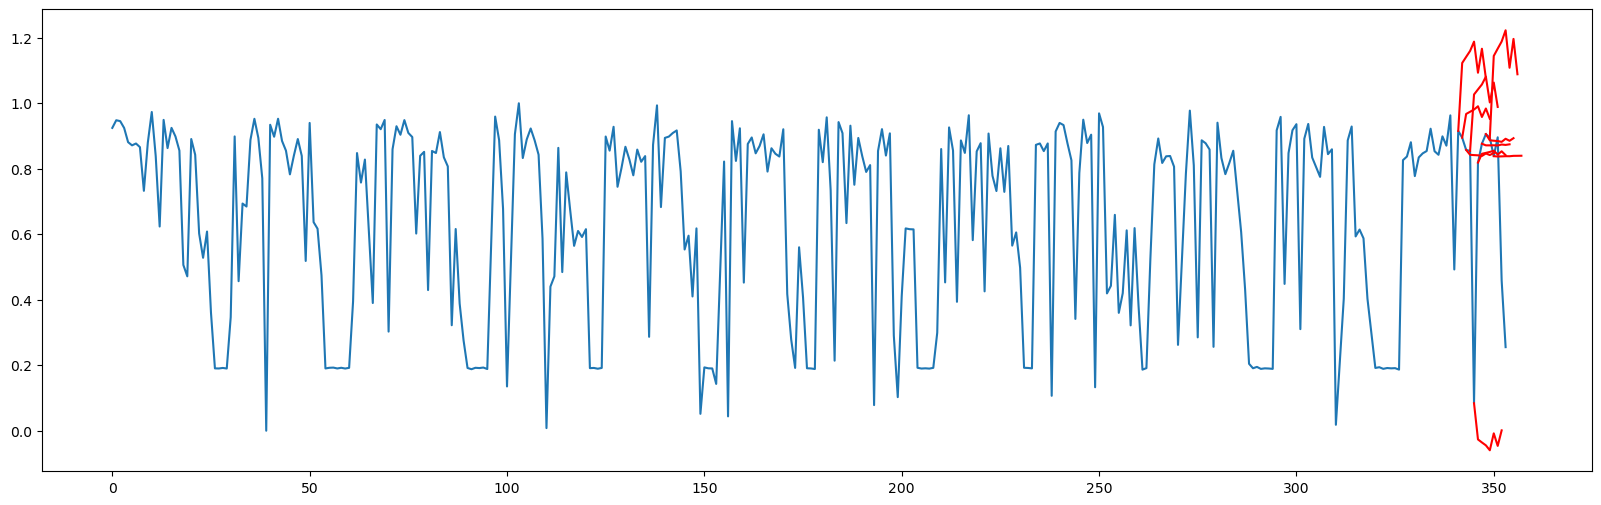

In [39]:
# plot forecasts
plot_forecasts(pd.DataFrame(cpu_usage_scaled), forecasts, n_test+2)

Multistep forecasting not good due to lack of data, but it is still a very good exercise :)